## <span style="font-family:cursive;text-align:center"><font color=blue> MLflow Model Experimentation </span>
    
This is a sample Guide on how to track the model experiments and registers the model and further model serving. This guide is based on iris dataset

#### Topics Covered:

* Model training important steps written as python function
* Train basic classifier and log it as a experiment


* Different methods to register ML model in MLFlow Registry
* Transition Model stage : None(default), Staging, Production or Archived
* Load Model from MLflow Registry and do Prediction
* Model Serving - Serving an ML Model from MLFlow Model Registry

will see how to log various paramets, model metrics, model itself and other aertifacts like charts etc.

In [1]:
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q mlflow
!mlflow --version

mlflow, version 2.10.2


In [23]:
import pandas as pd
data = pd.read_csv('iris.csv')
data.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

### Create functions for all the steps involved in complete model training lifecycle
Note: Model creation is not the main purpose of this notebook so not everything related to data cleaning and preprocessing is present. Main idea is to understand how to track experiment using MLFlow.

In [4]:
def load_data(url):
    import pandas as pd
    
    # Load dataset
    data = pd.read_csv('iris.csv')
    return data

In [5]:
def train_test_split(final_data,target_column):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != target_column]
    y = final_data.loc[:, final_data.columns == target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

In [6]:
def training_basic_classifier(X_train,y_train):
    from sklearn.linear_model import LogisticRegression
    classifier = LogisticRegression()
    classifier.fit(X_train,y_train)
    
    return classifier

In [7]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [8]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [9]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred,average='micro')
    recall = recall_score(y_true, y_pred,average='micro')
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [12]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

In [13]:
def create_confusion_matrix_plot(clf, y_test, y_pred):
    import matplotlib.pyplot as plt
    import seaborn as sb
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
                yticklabels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the figure
    plt.savefig('confusion_matrix.png')

### Start calling above functions one by one and see the output

**Data Loading**

In [15]:
url = 'https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/iris.csv'
data = load_data(url)
data

,Id,sepal-length,sepal-width,petal-length,petal-width,class
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [16]:
data['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

**Train-Test Split**

In [17]:
target_column = 'class'
X_train, X_test, y_train, y_test = train_test_split(data, target_column)

In [18]:
X_test.head()

,Id,sepal-length,sepal-width,petal-length,petal-width
26,27,5.0,3.4,1.6,0.4
41,42,4.5,2.3,1.3,0.3
49,50,5.0,3.3,1.4,0.2
44,45,5.1,3.8,1.9,0.4
141,142,6.9,3.1,5.1,2.3


**Model Training** 

In [20]:
model = training_basic_classifier(X_train,y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**See the prediction outcome**

In [21]:
y_pred = predict_on_test_data(model,X_test)
print(y_pred)
y_pred_prob = predict_prob_on_test_data(model,X_test)
print(y_pred_prob)

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-setosa' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor']
[[9.67859551e-01 3.21404492e-02 4.16752316e-12]
 [5.84671004e-01 4.15328995e-01 7.85449228e-10]
 [8.65675820e-01 1.34324177e-01 2.79695400e-09]
 [9.07840733e-01 9.21592658e-02 1.43991151e-09]
 [2.13615853e-10 2.87246772e-06 9.99997127e-01]
 [2.41092063e

**print some metrics**

In [22]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [23]:
run_metrics

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'entropy': 0.05}

**Generate Confusion Matrix**

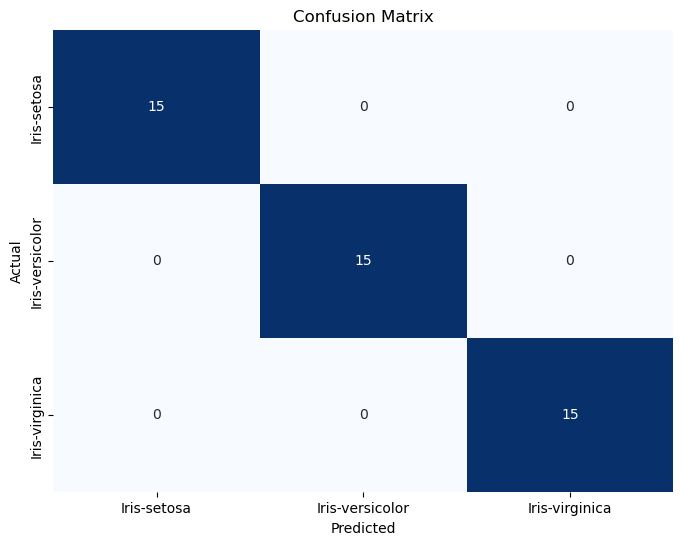

<Figure size 640x480 with 0 Axes>

In [65]:
create_confusion_matrix_plot(model, y_test, y_pred)

### Define create_experiment function to track your model experiment within MLFlow

In [66]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    
    MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    #use above line if you want to use any database like sqlite as backend storage for model else comment this line
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name):
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Iris Classifier")
        mlflow.set_tags({"tag2":"Logistic Regression", "tag3":"Multiclassification using Ovr - One vs rest class"})
        mlflow.sklearn.log_model(model, "model")
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

### Start Mlflow server

To use model registry, you need to have some backend database other than the file system. Ex mysql, sqlite or any other DB mentioned in mlflow docs under backend storage. Refer: https://www.mlflow.org/docs/latest/tracking.html?highlight=scenario#how-runs-and-artifacts-are-recorded

**Execute the create_experiment function and log experiment**

In [67]:
from datetime import datetime
experiment_name = "iris_classifier_"+ str(datetime.now().strftime("%d-%m-%y")) ##basic classifier
run_name="iris_classifier_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png')

2024/02/11 04:38:47 INFO mlflow.tracking.fluent: Experiment with name 'iris_classifier_11-02-24' does not exist. Creating a new experiment.


Run - iris_classifier_11-02-24 is logged to Experiment - iris_classifier_11-02-24


C:\Users\Admin\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [20]:
import mlflow
logged_model = 'runs:/507f4880d6df4b8b920c385b759e5d69/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor'], dtype=object)

**Open mlflow ui setup using ngrok in the browser, here you will find the recorded experiment**

### Adding an MLflow Model to the Model Registry
Reference: https://www.mlflow.org/docs/latest/model-registry.html

There are three programmatic ways to add a model to the registry. 
First, you can use the mlflow.<model_flavor>.log_model() method. 
For example, in your code:

#### Method 1

In [27]:
def create_exp_and_register_model(experiment_name,run_name,run_metrics,model,confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    
    import mlflow
    MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) 
    #use above line if you want to use any database like sqlite as backend storage for model else comment this line
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name) as run:
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
        mlflow.sklearn.log_model(model, "model",registered_model_name="iris-classifier")

In the above code snippet, if a registered model with the name doesn’t exist, the method registers a new model and creates Version 1. If a registered model with the name exists, the method creates a new model version.

In [28]:
experiment_name = "iris_classifier_method-1" #+ str(datetime.now().strftime("%d-%m-%y")) ##basic classifier
run_name="iris_classifier_method-1" #+str(datetime.now().strftime("%d-%m-%y"))
create_exp_and_register_model(experiment_name,run_name,run_metrics,model,'confusion_matrix.png')

2024/02/11 05:04:05 INFO mlflow.tracking.fluent: Experiment with name 'iris_classifier_method-1' does not exist. Creating a new experiment.
C:\Users\Admin\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'iris-classifier'.
Created version '1' of model 'iris-classifier'.


#### Method 2
The second way is to use the mlflow.register_model() method, after all your experiment runs complete and when you have decided which model is most suitable to add to the registry. For this method, you will need the run_id as part of the runs:URI argument.

In [23]:
import mlflow
with mlflow.start_run(run_name=run_name) as run:
    result = mlflow.register_model(
        "runs:/507f4880d6df4b8b920c385b759e5d69/model",
        "iris-classifier-2"
    )

Successfully registered model 'iris-classifier-2'.
2022/12/05 10:24:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: iris-classifier-2, version 1
Created version '1' of model 'iris-classifier-2'.


If a registered model with the name doesn’t exist, the method registers a new model, creates Version 1, and returns a ModelVersion MLflow object. If a registered model with the name exists, the method creates a new model version and returns the version object.

#### Method 3
And finally, you can use the create_registered_model() to create a new registered model. If the model name exists, this method will throw an MlflowException because creating a new registered model requires a unique name.

In [31]:
import mlflow
client = mlflow.tracking.MlflowClient()
client.create_registered_model("basic-classifier-method-3")
#While the method above creates an empty registered model with no version associated, 

<RegisteredModel: aliases={}, creation_timestamp=1707669413252, description=None, last_updated_timestamp=1707669413252, latest_versions=[], name='basic-classifier-method-3', tags={}>

In [32]:
#the method below creates a new version of the model.
client = mlflow.tracking.MlflowClient()
result = client.create_model_version(
    name="basic-classifier-method-3",
    source="507f4880d6df4b8b920c385b759e5d69/artifacts/model",
    run_id="507f4880d6df4b8b920c385b759e5d69"
)

### Fetching an MLflow Model from the Model Registry

**Fetch a specific model version**

In [33]:
import mlflow.pyfunc

model_name = "iris-classifier"
model_version = 1

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

y_pred = model.predict(X_test)
print(y_pred)

sklearn_model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)
y_pred_prob = sklearn_model.predict_proba(X_test)
print(y_pred_prob)

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-setosa' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor']
[[9.67859551e-01 3.21404492e-02 4.16752316e-12]
 [5.84671004e-01 4.15328995e-01 7.85449228e-10]
 [8.65675820e-01 1.34324177e-01 2.79695400e-09]
 [9.07840733e-01 9.21592658e-02 1.43991151e-09]
 [2.13615853e-10 2.87246772e-06 9.99997127e-01]
 [2.41092063e

**Fetch the latest model version in a specific stage**

To fetch a model version by stage, simply provide the model stage as part of the model URI, and it will fetch the most recent version of the model in that stage.

#### Transitioning an MLflow Model’s Stage

In [34]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name="iris-classifier",
    version=1,
    stage="Production"
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4420\2392087708.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1707656655822, current_stage='Production', description=None, last_updated_timestamp=1707669548022, name='iris-classifier', run_id='9a5ba6a83bac4e5e8f85f5485e2a736b', run_link=None, source='file:///C:/Users/Admin/mlflow-setup/Full-stack-MLOPS/model-experimentation/mlruns/3/9a5ba6a83bac4e5e8f85f5485e2a736b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [35]:
import mlflow.pyfunc

model_name = "iris-classifier"
stage = 'Production'

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{stage}"
)

y_pred = model.predict(X_test)
print(y_pred)

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-setosa' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor']


C:\Users\Admin\anaconda3\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [44]:
import mlflow.pyfunc

model_name = "iris-classifier"
stage = 'Production'

model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}/{stage}"
)

y_pred = model.predict([[6.7,3.3,5.7,2.1,1]])
print(y_pred)
y_pred_prob = model.predict_proba([[6.7,3.3,5.7,2.1,1]])
print(y_pred_prob)

['Iris-setosa']
[[9.95213256e-01 4.78674405e-03 1.98442091e-14]]


C:\Users\Admin\anaconda3\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Model Serving

serving an MLflow Model from Model Registry

**Run this from command line**
`set MLFLOW_TRACKING_URI=http://localhost:5000` #use export MLFLOW_TRACKING_URI=http://localhost:5000 if in linux

## **Now run this command from command line**

make sure to write the different port - other than the one you used while starting mlflow server

`mlflow models serve --model-uri models:/iris-classifier/Production -p 1234 --no-conda`



### Do Prediction

In [48]:
import requests

inference_request = {
        "dataframe_records": [[6.7,3.3,5.7,2.1,1]]
}
endpoint = "http://127.0.0.1:1234/invocations"

response = requests.post(endpoint, json=inference_request)

print(response.text)

{"predictions": ["Iris-setosa"]}


### Batch Prediction

In [20]:
X_test

,sepal-length,sepal-width,petal-length,petal-width
26,5.0,3.4,1.6,0.4
41,4.5,2.3,1.3,0.3
49,5.0,3.3,1.4,0.2
44,5.1,3.8,1.9,0.4
141,6.9,3.1,5.1,2.3
108,6.7,2.5,5.8,1.8
86,6.7,3.1,4.7,1.5
142,5.8,2.7,5.1,1.9
65,6.7,3.1,4.4,1.4
61,5.9,3.0,4.2,1.5


In [49]:
import requests
lst = X_test.values.tolist()
inference_request = {
        "dataframe_records": lst
}
endpoint = "http://localhost:1234/invocations"
response = requests.post(endpoint, json=inference_request)
print(response)

<Response [200]>


In [50]:
print(response.text)

{"predictions": ["Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-virginica", "Iris-virginica", "Iris-versicolor", "Iris-virginica", "Iris-versicolor", "Iris-versicolor", "Iris-virginica", "Iris-versicolor", "Iris-versicolor", "Iris-setosa", "Iris-setosa", "Iris-virginica", "Iris-setosa", "Iris-versicolor", "Iris-versicolor", "Iris-versicolor", "Iris-versicolor", "Iris-virginica", "Iris-virginica", "Iris-setosa", "Iris-setosa", "Iris-virginica", "Iris-virginica", "Iris-setosa", "Iris-versicolor", "Iris-versicolor", "Iris-setosa", "Iris-virginica", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-versicolor", "Iris-versicolor", "Iris-virginica", "Iris-virginica", "Iris-versicolor", "Iris-versicolor"]}


### For model serving/Deployment

1. Deploy Model using Python Flask and expose end points
2. Deploy Model using FastAPI